# **Capítulo 6: Redes neuronales recurrentes**

## Predicción del valor en bolsa de una compañía

Descargamos los datos del caso práctico

In [ ]:
!wget -q https://github.com/deep-learning-keras-pytorch/deep-learning-keras-pytorch.github.io/blob/master/docs/cap6/AAPL.csv

Carga y visualización de los datos del caso práctico

In [ ]:
import pandas as pd

# Leemos el fichero
data = pd.read_csv('AAPL.csv', parse_dates=['Date'])
# Mostramos las 5 primeras filas
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-12-31,72.932854,76.485718,72.714287,76.024284,67.190933,164873100
1,2013-01-02,79.117142,79.285713,77.375717,78.432854,69.319641,140129500
2,2013-01-03,78.268570,78.524284,77.285713,77.442856,68.444672,88241300
3,2013-01-04,76.709999,76.947144,75.118568,75.285713,66.538162,148583400
4,2013-01-07,74.571426,75.614288,73.599998,74.842857,66.146751,121039100


Mostramos una gráfica con el precio de apertura de la acción

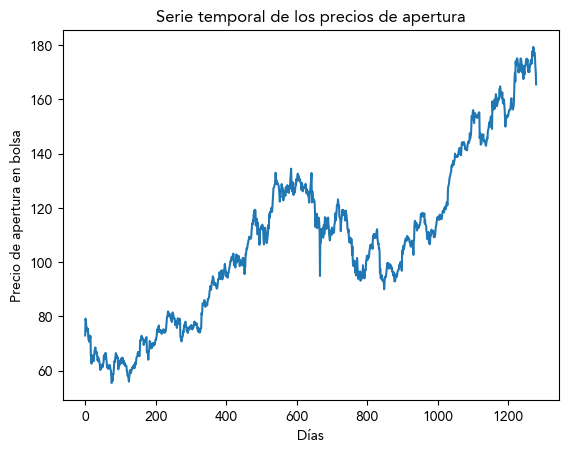

In [3]:
import matplotlib.pyplot as plt

data['Open'].plot()
plt.xlabel('Días')
plt.ylabel('Precio de apertura en bolsa')
plt.title('Serie temporal de los precios de apertura')
plt.show()

Normalización de los datos

In [4]:
import numpy as np

# Normalizamos los datos
data['Open Scaled'] = (data['Open'] - np.min(data['Open'])) / (np.max(data['Open']) - np.min(data['Open']))
# Comprobamos que los datos están normalizados
data[['Open', 'Open Scaled']].head()

,Open,Open Scaled
0,72.932854,0.141260
1,79.117142,0.191155
2,78.268570,0.184309
3,76.709999,0.171734
4,74.571426,0.154480


Preparación de los datos para entrenar la red neuronal

In [5]:
import torch

N = 60

# Guardamos los valores de apertura en un vector
vals_norm = data['Open Scaled'].values

X = [] # Matriz base para predecir
Y = [] # Vector con la etiquetas
for i in range(N, len(vals_norm)):
    X.append(vals_norm[i-N:i])
    Y.append(vals_norm[i])
# Los convertimos a tensores de PyTorch
X = np.array(X, dtype='float32')
X = torch.from_numpy(X)
X = X.unsqueeze(dim=2)  # [batch, num_elem, input_size]
Y = np.array(Y, dtype='float32')
Y = Y.reshape(-1, 1)    # [batch, 1]
Y = torch.from_numpy(Y)

# Dimensiones de los conjuntos de datos
print(f'Tamaño del conjunto de datos de entrada: {X.shape}')
print(f'Tamaño del conjunto de datos de salida: {Y.shape}')

Tamaño del conjunto de datos de entrada: torch.Size([1220, 60, 1])
Tamaño del conjunto de datos de salida: torch.Size([1220, 1])


Creación de los conjuntos de entrenamiento y test

In [6]:
from torch.utils.data import TensorDataset, DataLoader

# Últimos 30 días para test, el resto para entrenamiento
X_train, X_test = X[:-30], X[-30:]
Y_train, Y_test = Y[:-30], Y[-30:]

# Datos de entrenamiento
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Datos de test
test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Comprobación de acceso a GPU

In [8]:
dispositivo = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando {dispositivo}')

Usando cuda


Implementación de la RNN

In [9]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.lstm = nn.LSTM(input_size=1, hidden_size=128,\
                            batch_first=True)
        self.linear = nn.Linear(128, 1)

    def forward(self, x):
        salida, _ = self.lstm(x)
        salida = salida[:, -1, :]
        salida = self.linear(salida)
        return salida

modelo = RNN()
# Si es posible, movemos el modelo a la GPU
modelo.to(dispositivo)

RNN(
  (lstm): LSTM(1, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

Implementación de la función de entrenamiento

In [10]:
def epoca_train(modelo, train_loader, optimizador,\
                func_perdida, dispositivo):
    epoca_perdidas = []
    # Iteramos sobre los datos de entrenamiento
    for i, (x, y) in enumerate(train_loader):
        # Si es posible, transferimos los datos a la GPU
        x = x.to(dispositivo)
        y = y.to(dispositivo)
        # Ponemos los gradientes a cero
        optimizador.zero_grad()
        # Calculamos las salidas de la red neuronal
        # para las entradas
        y_pred = modelo(x)
        # Calculamos la pérdida de la red neuronal
        perdida = func_perdida(y_pred, y)
        # Calculamos los gradientes de la pérdida
        # respecto a los parámetros de la red neuronal
        perdida.backward()
        # Actualizamos los parámetros de la red neuronal
        # usando el algoritmo de optimización
        optimizador.step()
        # Añadimos a la lista de pérdidas la pérdida actual
        epoca_perdidas.append(perdida.item())
    # Calculamos la media de las pérdidas para una época
    return sum(epoca_perdidas) / len(epoca_perdidas)

Entrenamiento del modelo

In [13]:
import torch.optim as optim

# Learning rate de 0.001 por defecto
optimizador = optim.Adam(modelo.parameters())
# Función de pérdida de entropía cruzada
func_perdida = nn.MSELoss()

# Definimos el número de épocas de entrenamiento
epocas = 50
# Iteramos por cada época
for epoca in range(epocas):
    # Entrenamos la red neuronal por una época
    train_perdida = epoca_train(
        modelo, train_loader, optimizador, func_perdida, dispositivo)
    # Sacamos los resultados por pantalla
    print(f'Época {epoca+1}/{epocas}, pérdida={train_perdida:.4f}')
# Se ha completado el entrenamiento de la red neuronal
print('Fin del entrenamiento.')


Época 1/50, pérdida=0.0574
Época 2/50, pérdida=0.0056
Época 3/50, pérdida=0.0013
Época 4/50, pérdida=0.0007
Época 5/50, pérdida=0.0007
Época 6/50, pérdida=0.0007
Época 7/50, pérdida=0.0007
Época 8/50, pérdida=0.0006
Época 9/50, pérdida=0.0006
Época 10/50, pérdida=0.0006
Época 11/50, pérdida=0.0005
Época 12/50, pérdida=0.0005
Época 13/50, pérdida=0.0005
Época 14/50, pérdida=0.0005
Época 15/50, pérdida=0.0006
Época 16/50, pérdida=0.0006
Época 17/50, pérdida=0.0005
Época 18/50, pérdida=0.0004
Época 19/50, pérdida=0.0005
Época 20/50, pérdida=0.0005
Época 21/50, pérdida=0.0004
Época 22/50, pérdida=0.0004
Época 23/50, pérdida=0.0004
Época 24/50, pérdida=0.0005
Época 25/50, pérdida=0.0004
Época 26/50, pérdida=0.0005
Época 27/50, pérdida=0.0005
Época 28/50, pérdida=0.0004
Época 29/50, pérdida=0.0005
Época 30/50, pérdida=0.0004
Época 31/50, pérdida=0.0004
Época 32/50, pérdida=0.0004
Época 33/50, pérdida=0.0004
Época 34/50, pérdida=0.0004
Época 35/50, pérdida=0.0004
Época 36/50, pérdida=0.0004
É

Predicción sobre el conjunto de datos de test

In [14]:
Y_pred = []

# Establecemos la red neuronal en modo de evaluación
modelo.eval()
# Desactivamos el cálculo de gradientes
with torch.no_grad():
    # Iteramos sobre los datos de test
    for x, y in test_loader:
        # Si es posible, transferimos los datos a la GPU
        x = x.to(dispositivo)
        y = y.to(dispositivo)
        # Calculamos las salidas de la red neuronal
        # para las entradas
        Y_pred.append(modelo(x).detach().cpu().numpy())

Y_pred = np.concatenate(Y_pred)

Visualización de las predicciones del modelo entrenado

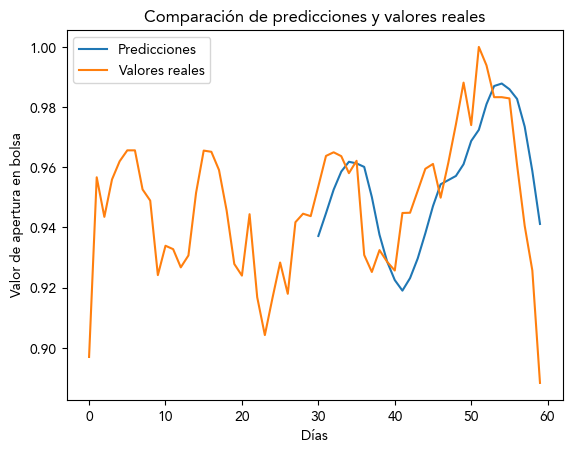

In [15]:
plt.plot(range(30, 60), Y_pred.flatten(), label='Predicciones')
plt.plot(range(60), Y[-60:].numpy(), label='Valores reales')
plt.xlabel('Días')
plt.ylabel('Valor de apertura en bolsa')
plt.title('Comparación de predicciones y valores reales')
plt.legend()
plt.show()